In [9]:
try:
  import jax
except ModuleNotFoundError:
  %pip install jaxlib jax
  import jax
import jax.numpy as jnp
try:
  import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
  %pip install tensorflow-probability
  import tensorflow_probability.substrates.jax as tfp
tfd=tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm import trange
try:
  import optax
except ModuleNotFoundError:
  %pip install optax
  import optax
from sklearn.datasets import make_classification

### **Creating the Dataset**

In [10]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

In [11]:
data = jnp.c_[X, y]
X,y=data[:,:-1],data[:,-1]

### **Defining the function for the negative log joint**

In [12]:
def neg_logjoint(theta, data):
    X, y = data[:, :-1], data[:, -1]
    l = tfd.Bernoulli(probs=jax.nn.sigmoid(X @ theta[:-1] + theta[-1]))
    p=tfd.MultivariateNormalDiag(loc=[0.0, 0.0, 0.0], scale_diag=[1.0, 1.0, 1.0])
    return -(l.log_prob(y).sum()+p.log_prob(theta))

In [13]:
gradient=jax.value_and_grad(jax.jit(neg_logjoint))
seed=jax.random.PRNGKey(0)
theta_map = jax.random.uniform(shape=(3,), key=seed)
lr=0.01
optimizer = optax.adam(learning_rate=lr)
state = optimizer.init(theta_map)
losses = []
max_iter=1000
for _ in trange(max_iter):
    val, grad = gradient(theta_map, data)
    losses.append(val)
    update, state = optimizer.update(grad, state)
    theta_map = optax.apply_updates(theta_map, update)
loss=losses
theta_map

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.35it/s]


DeviceArray([-2.378012 ,  0.542598 ,  1.2319461], dtype=float32)

### **Normal Laplace approximation**

In [14]:
hessian=jax.hessian(neg_logjoint)(theta_map,data)

In [15]:
cov = jnp.linalg.inv(hessian)
cov

DeviceArray([[ 0.15795618, -0.05703399, -0.04706418],
             [-0.05703408,  0.12439726, -0.16532138],
             [-0.047064  , -0.16532151,  0.427078  ]], dtype=float32)

In [16]:
laplace_approx=tfd.MultivariateNormalFullCovariance(loc=theta_map, covariance_matrix=cov)

Text(0.5, 0.98, 'Laplace Approx of Logistic Regression posterior')

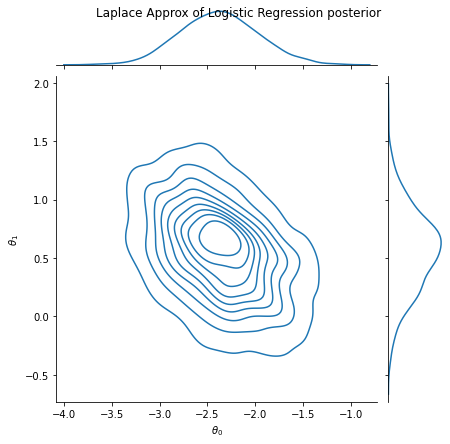

In [17]:
samples = laplace_approx.sample(sample_shape=(1000,), seed=jax.random.PRNGKey(0))
s1 = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
s1.set_axis_labels(r"$\theta_0$", r"$\theta_1$")
s1.fig.suptitle("Laplace Approx of Logistic Regression posterior")

### **Diagonal Laplace Approximation**

In [18]:
cov_diagonal=jnp.diag(1/(jnp.diag(hessian)))

In [19]:
cov_diagonal

DeviceArray([[0.05901479, 0.        , 0.        ],
             [0.        , 0.02333304, 0.        ],
             [0.        , 0.        , 0.09284668]], dtype=float32)

Text(0.5, 0.98, 'Digonal Laplace Approx of Logistic Regression posterior')

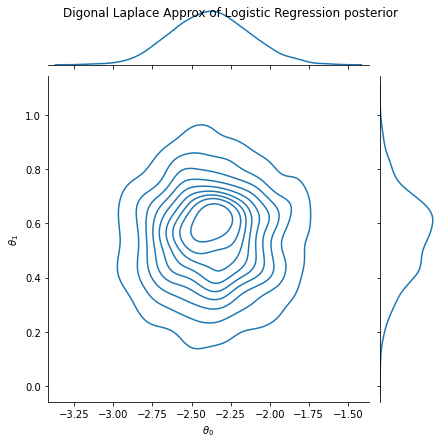

In [20]:
laplace_approx_diag=tfd.MultivariateNormalFullCovariance(loc=theta_map, covariance_matrix=cov_diagonal)
samples_diag = laplace_approx_diag.sample(sample_shape=(1000,), seed=jax.random.PRNGKey(0))
s2 = sns.jointplot(x=samples_diag[:, 0], y=samples_diag[:, 1], kind="kde")
s2.set_axis_labels(r"$\theta_0$", r"$\theta_1$")
s2.fig.suptitle("Digonal Laplace Approx of Logistic Regression posterior")

## **Comparison b/w Diagonal Approximation and Standard Laplace**

/tmp/ipykernel_15079/403621869.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X,Y,Z,levels=20,colors='red',label="Laplace")
/tmp/ipykernel_15079/403621869.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X,Y,Z2,levels=20,colors='black',label="Diagonal Laplace")


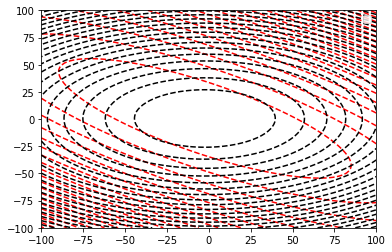

In [21]:
x = jnp.linspace(-100, 100, 100)
y = jnp.linspace(-100,100, 100)
X,Y = jnp.meshgrid(x, y)

# Laplace Approximation
Z = jax.vmap(jax.vmap(lambda i, j: laplace_approx.log_prob(jnp.array([i, j,1.]))))(X, Y)

# Diagonal Laplace Approximation
Z2=jax.vmap(jax.vmap(lambda i, j: laplace_approx_diag.log_prob(jnp.array([i, j,1.]))))(X, Y)
plt.contour(X,Y,Z,levels=20,colors='red',label="Laplace")
plt.contour(X,Y,Z2,levels=20,colors='black',label="Diagonal Laplace")
plt.legend()

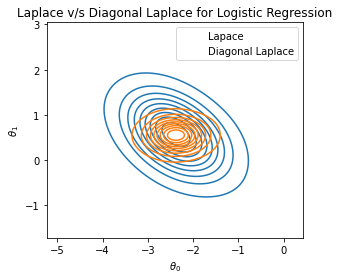

In [22]:
fig, ax = plt.subplots()
samples = laplace_approx.sample(sample_shape=(1000,), seed=jax.random.PRNGKey(0))
s = {r'$\theta_0$': samples[:, 0], r'$\theta_1$': samples[:, 1]}
ax = sns.kdeplot(data=s, x=r'$\theta_0$', y=r'$\theta_1$', label="Lapace",bw_adjust=4)

sample_diag = laplace_approx_diag.sample(sample_shape=(1000,), seed=jax.random.PRNGKey(0))
s1 = {r'$\theta_0$': sample_diag[:, 0], r'$\theta_1$': sample_diag[:, 1]}
ax = sns.kdeplot(data=s1, x=r'$\theta_0$', y=r'$\theta_1$', label="Diagonal Laplace",bw_adjust=4)

ax.set_title("Laplace v/s Diagonal Laplace for Logistic Regression")
ax.set_aspect("equal")
plt.legend()
fig.tight_layout()